
# Rocket — **Unified Pro Matching & Team Formation** (Local/Global + Radar Viz)

A consolidated notebook that powers three core flows:
1) **Network expansion** — find people with **similar skills & interests** who also fit **professionally and personally**.  
2) **Team formation** (local or global) — assemble **complementary** skills to solve a brief.  
3) **Field/passion discovery** — find people **interested in a field** and demonstrate relevant skills.

**Production-minded features**
- Multilingual semantic embeddings (SBERT if available, TF‑IDF fallback).
- Two-stage retrieval: hard **candidate filtering** (geo + language in local mode) → learned **ranking blend**.
- Content similarity + **skills similar/complementary** (Hungarian coverage) + **role archetype complementarity**.
- Social fit: **personality (TIPI→Big Five)**, energy, collaboration style, availability, time zone.
- **Collaborative filtering** (implicit MF) + **Graph lift** (PPR) over interactions.
- **Diversification** (MMR/DPP-style greedy).
- **Strict local gating** (radius + shared language) – no remote padding.
- **Real names** (diverse, synthetic), diverse roles beyond Writer/Engineer/Scientist.
- **Radar chart** to visualize similarity dimensions for a specific match.


## Optional installs (run locally if needed)

In [1]:

# !pip install numpy pandas scikit-learn networkx geopy scipy
# !pip install sentence-transformers
# (For resume parsing) !pip install spacy python-docx pdfplumber
# !python -m spacy download en_core_web_sm


## Imports & setup

In [3]:
!pip install networkx matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 82.0 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 99.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


In [2]:
!which python

/Users/camerondeardon/anaconda3/bin/python


In [1]:
import numpy as np, pandas as pd, random, math, importlib, re
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Tuple
from datetime import date, datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from geopy.distance import geodesic
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(1337); random.seed(1337)


## Embeddings — multilingual SBERT preferred; TF‑IDF fallback

In [3]:

class Embedder:
    def __init__(self, model_names: List[str] = None):
        self.model = None
        self.sbert_ok = False
        self.tfidf = None
        self.model_names = model_names or [
            "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
            "sentence-transformers/distiluse-base-multilingual-cased-v2",
            "sentence-transformers/all-MiniLM-L6-v2"
        ]
        if importlib.util.find_spec("sentence_transformers") is not None:
            from sentence_transformers import SentenceTransformer
            for name in self.model_names:
                try:
                    self.model = SentenceTransformer(name)
                    self.sbert_ok = True
                    break
                except Exception:
                    continue

    def fit(self, corpus: List[str]):
        if self.sbert_ok: return self
        self.tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=1)
        self.tfidf.fit(corpus)
        return self

    def encode(self, items: List[str]) -> np.ndarray:
        if self.sbert_ok:
            return np.array(self.model.encode(items, show_progress_bar=False, normalize_embeddings=True))
        X = self.tfidf.transform(items)
        X = X.astype(np.float64)
        norms = np.sqrt((X.power(2)).sum(axis=1))
        norms[norms==0] = 1.0
        return (X / norms).toarray()


## Utilities — DOB→Age & TIPI personality

In [4]:

def parse_dob(dob_str: str) -> date:
    return datetime.strptime(dob_str, "%Y-%m-%d").date()

def compute_age(dob: date, today: Optional[date] = None) -> int:
    today = today or date.today()
    years = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return max(0, years)

def age_band(age: int) -> str:
    for lo, hi in [(18,24),(25,34),(35,44),(45,54)]:
        if lo <= age <= hi: return f"{lo}-{hi}"
    return "55+"

@dataclass
class BigFive:
    O: float; C: float; E: float; A: float; N: float

def clip01(x): 
    import numpy as np
    return float(np.clip(x, 0.0, 1.0))

TIPI_KEY = {
    1: ("E", False), 2: ("A", True), 3: ("C", False), 4: ("N", False), 5: ("O", False),
    6: ("E", True),  7: ("A", False),8: ("C", True),  9: ("N", True),  10:("O", True)
}

def score_tipi(responses_1to7):
    import numpy as np
    assert len(responses_1to7)==10
    r = np.array(responses_1to7, dtype=float)
    r01 = (r-1)/6.0  # 1..7 -> 0..1
    traits = {"O":[], "C":[], "E":[], "A":[], "N":[]}
    for i,val in enumerate(r01, start=1):
        trait, rev = TIPI_KEY[i]
        traits[trait].append(1.0-val if rev else val)
    return BigFive(*(clip01(np.mean(traits[t])) for t in ["O","C","E","A","N"]))

def bigfive_cosine(u: BigFive, v: BigFive) -> float:
    import numpy as np
    a = np.array([u.O,u.C,u.E,u.A,u.N])
    b = np.array([v.O,v.C,v.E,v.A,v.N])
    return float(a @ b / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-9))


## Roles → Archetypes (dynamic complementarity)

In [5]:

# Map many roles to a small set of archetypes; define complementarity on archetypes (dense coverage).
ARCHETYPES = ["Maker","Storyteller","Researcher","Operator","Seller"]
ROLE2ARCH = {
    "Founder":"Operator","Engineer":"Maker","Designer":"Maker","Researcher":"Researcher",
    "Writer":"Storyteller","Scientist":"Researcher","Creator":"Storyteller","Product Manager":"Operator",
    "Marketer":"Seller","Growth":"Seller","Data Analyst":"Researcher","Data Engineer":"Maker",
    "ML Engineer":"Maker","Community Manager":"Seller","Operations":"Operator","Finance":"Operator",
    "Legal":"Operator","Sales":"Seller","DevRel":"Storyteller","Content Strategist":"Storyteller",
    "Video Producer":"Storyteller","UX Researcher":"Researcher","Bioengineer":"Maker","Hardware Engineer":"Maker",
    "Game Designer":"Maker","Composer":"Storyteller","Illustrator":"Storyteller","Photographer":"Storyteller",
    "Entrepreneur":"Operator","Strategist":"Operator","UX Designer":"Maker","Mobile Developer":"Maker"
}
ARCH_COMP = {  # synergy between archetypes (0..1)
    ("Maker","Maker"):0.35, ("Maker","Storyteller"):0.9, ("Maker","Researcher"):0.75, ("Maker","Operator"):0.85, ("Maker","Seller"):0.8,
    ("Storyteller","Storyteller"):0.35, ("Storyteller","Researcher"):0.6, ("Storyteller","Operator"):0.8, ("Storyteller","Seller"):0.9,
    ("Researcher","Researcher"):0.3, ("Researcher","Operator"):0.7, ("Researcher","Seller"):0.55,
    ("Operator","Operator"):0.4, ("Operator","Seller"):0.85,
    ("Seller","Seller"):0.4
}
def role_comp_matrix(roles: List[str]) -> np.ndarray:
    n=len(roles); S=np.zeros((n,n))
    for i in range(n):
        ai = ROLE2ARCH.get(roles[i], "Operator")
        for j in range(n):
            if i==j: continue
            aj = ROLE2ARCH.get(roles[j], "Operator")
            S[i,j] = ARCH_COMP.get((ai,aj), ARCH_COMP.get((aj,ai), 0.5))
    return S


## Feature builders — content, geo, experience, social fit, language

In [6]:

def build_text_similarity(df: pd.DataFrame, embedder):
    corpus = (df['interests'].fillna('') + " ; " + df['skills_have'].fillna('') + " ; " + df['professional'].fillna('')).tolist()
    embedder.fit(corpus)
    X = embedder.encode(corpus)
    S = (X @ X.T)
    S = (S - S.min())/(S.max()-S.min()+1e-9)
    return S

def language_overlap(df: pd.DataFrame) -> np.ndarray:
    n=len(df); S=np.zeros((n,n))
    langs = [set([x.strip().lower() for x in (l or "").split(",") if x.strip()]) for l in df['languages'].fillna('')]
    for i in range(n):
        for j in range(n):
            if i==j: continue
            inter = langs[i] & langs[j]
            uni = langs[i] | langs[j]
            S[i,j] = len(inter)/float(len(uni) + 1e-9)
    return S

def distance_matrix(df: pd.DataFrame) -> np.ndarray:
    n=len(df); D=np.zeros((n,n))
    coords = list(zip(df['lat'], df['lon']))
    for i in range(n):
        for j in range(n):
            if i==j: continue
            D[i,j] = geodesic(coords[i], coords[j]).km
    return D

def geo_similarity_from_D(D: np.ndarray, decay_km: float = 1200.0) -> np.ndarray:
    S = np.exp(-D/decay_km)
    if S.max()>0: S = S/S.max()
    np.fill_diagonal(S, 0.0)
    return S

def experience_compatibility(years: List[int], sweet_spot: float = 3.0) -> np.ndarray:
    years = np.array(years); n=len(years); S=np.zeros((n,n),dtype=float)
    for i in range(n):
        for j in range(n):
            if i==j: continue
            gap = abs(years[i]-years[j])
            S[i,j] = np.exp(-((gap-sweet_spot)**2)/(2*(sweet_spot**2)))
    if S.max()>0: S = S/S.max()
    return S

def energy_compatibility(energies: List[int], target_gap=0):
    e = np.array(energies); n=len(e); S=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i==j: continue
            gap = abs(e[i]-e[j])
            S[i,j] = np.exp(-((gap-target_gap)**2)/(2*(1.25**2)))
    if S.max()>0: S = S/S.max()
    return S

COLLAB_COMP = {
    "async": {"async":1.0, "hybrid":0.7, "sync":0.3},
    "hybrid":{"async":0.7, "hybrid":1.0, "sync":0.7},
    "sync":  {"async":0.3, "hybrid":0.7, "sync":1.0},
}
def collab_style_compatibility(styles: List[str]) -> np.ndarray:
    n=len(styles); S=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i==j: continue
            S[i,j] = COLLAB_COMP.get(styles[i],{}).get(styles[j], 0.5)
    return S

def availability_overlap(avails: List[str]) -> np.ndarray:
    map_mid = {"2-5":3.5,"5-10":7.5,"10-20":15.0,"20+":25.0}
    v = np.array([map_mid.get(a,7.5) for a in avails])
    n=len(v); S=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i==j: continue
            gap = abs(v[i]-v[j])
            S[i,j] = np.exp(-gap/15.0)
    if S.max()>0: S = S/S.max()
    return S

def time_zone_overlap(tz_list: List[int]) -> np.ndarray:
    tz = np.array(tz_list); n=len(tz); S=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i==j: continue
            diff = abs(tz[i]-tz[j])
            S[i,j] = np.exp(-diff/6.0)
    if S.max()>0: S = S/S.max()
    return S


## Skills — similarity & complementarity

In [7]:

def parse_skill_list(sk: str) -> List[str]:
    return [s.strip().lower() for s in (sk or "").split(",") if s.strip()]

def tfidf_cosine(a_list: List[str], b_list: List[str]) -> float:
    docs = ["; ".join(a_list), "; ".join(b_list)]
    vec = TfidfVectorizer(ngram_range=(1,2), min_df=1)
    X = vec.fit_transform(docs)
    return float(cosine_similarity(X[0], X[1])[0,0])

def similar_skills_matrix(df: pd.DataFrame) -> np.ndarray:
    n=len(df); S=np.zeros((n,n))
    parsed = [parse_skill_list(x) for x in df['skills_have'].fillna('')]
    for i in range(n):
        for j in range(n):
            if i==j: continue
            S[i,j] = tfidf_cosine(parsed[i], parsed[j])
    if S.max()>0: S = S/S.max()
    return S

def complementary_skills_matrix(df: pd.DataFrame) -> np.ndarray:
    wants = [parse_skill_list(row.get('skills_want', row.get('interests',''))) for _,row in df.iterrows()]
    haves = [parse_skill_list(row.get('skills_have','')) for _,row in df.iterrows()]
    n=len(df); S=np.zeros((n,n))
    try:
        from scipy.optimize import linear_sum_assignment
        for i in range(n):
            need = wants[i]
            for j in range(n):
                if i==j: continue
                have = haves[j]
                if not need or not have: 
                    S[i,j]=0.0; continue
                A = ["; ".join([n1]) for n1 in need]
                B = ["; ".join([h1]) for h1 in have]
                vec = TfidfVectorizer(ngram_range=(1,2), min_df=1)
                X = vec.fit_transform(A + B)
                m, k = len(need), len(have)
                Csim = np.zeros((m,k))
                for p in range(m):
                    for q in range(k):
                        Csim[p,q] = cosine_similarity(X[p], X[m+q])[0,0]
                size = max(m,k)
                padded = np.ones((size,size))
                padded[:m,:k] = 1.0 - Csim  # cost = 1 - sim
                r_ind, c_ind = linear_sum_assignment(padded)
                total_sim = 0.0; count = 0
                for r,c in zip(r_ind, c_ind):
                    if r < m and c < k:
                        total_sim += 1.0 - padded[r,c]; count += 1
                S[i,j] = total_sim / (count + 1e-9)
        if S.max()>0: S = S/S.max()
    except Exception:
        for i in range(n):
            need = wants[i]
            for j in range(n):
                if i==j: continue
                have = haves[j]
                if not need or not have: 
                    S[i,j]=0.0; continue
                sims = [max(tfidf_cosine([nterm], [h]) for h in have) for nterm in need] if need else []
                S[i,j] = float(np.mean(sims)) if sims else 0.0
        if S.max()>0: S = S/S.max()
    return S


## CF (implicit MF), Graph (PPR), Personality; Fusion & strict local gating

In [8]:

def mf_als(R: np.ndarray, k: int = 16, alpha: float = 40.0, reg: float = 0.1, iters: int = 6):
    n_users, n_items = R.shape
    C = 1 + alpha * R  # confidence
    X = np.random.normal(scale=0.1, size=(n_users, k))
    Y = np.random.normal(scale=0.1, size=(n_items, k))
    eye = np.eye(k)
    for _ in range(iters):
        for u in range(n_users):
            Cu = np.diag(C[u])
            YTCuY = Y.T @ Cu @ Y
            YTCuPu = Y.T @ (Cu @ R[u])
            X[u] = np.linalg.solve(YTCuY + reg*eye, YTCuPu)
        for i in range(n_items):
            Ci = np.diag(C[:,i])
            XTCiX = X.T @ Ci @ X
            XTCiPi = X.T @ (Ci @ R[:,i])
            Y[i] = np.linalg.solve(XTCiX + reg*eye, XTCiPi)
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    S = Xn @ Xn.T
    S = (S - S.min())/(S.max()-S.min()+1e-9)
    np.fill_diagonal(S, 0.0)
    return S

def build_graph_ppr(R: np.ndarray, alpha=0.85) -> np.ndarray:
    n = R.shape[0]
    G = nx.DiGraph(); G.add_nodes_from(range(n))
    edges = [(u,v) for u in range(n) for v in range(n) if R[u,v]>0]
    G.add_edges_from(edges)
    S = np.zeros((n,n))
    for u in range(n):
        pr = nx.pagerank(G, alpha=alpha, personalization={k:(1.0 if k==u else 0.0) for k in range(n)})
        for v,s in pr.items(): S[u,v] = s
    S = (S - S.min())/(S.max()-S.min()+1e-12)
    np.fill_diagonal(S, 0.0)
    return S

def reciprocalize(S: np.ndarray) -> np.ndarray:
    return np.sqrt(S * S.T + 1e-12)

def combine_content(S_text, S_geo, S_exp, S_role, S_energy, S_collab, S_avail, S_tz, S_lang, w):
    a,b,c,d,e,f,g,h,l = w
    S = a*S_text + b*S_geo + c*S_exp + d*S_role + e*S_energy + f*S_collab + g*S_avail + h*S_tz + l*S_lang
    return S / (S.max() + 1e-9)

def fuse_scores(S_content, S_cf, S_graph, S_person, S_skills, weights=(0.28,0.18,0.16,0.12,0.26)):
    Sc = reciprocalize(S_content)
    Sf = reciprocalize(S_cf)
    Sg = reciprocalize(S_graph)
    Sp = reciprocalize(S_person)
    Ss = reciprocalize(S_skills)
    a,b,c,d,e = weights
    S = a*Sc + b*Sf + c*Sg + d*Sp + e*Ss
    return S / (S.max() + 1e-12)

def local_allowed_ids(df: pd.DataFrame, D: np.ndarray, query_idx: int, radius_km: float, require_shared_language: bool, S_lang: np.ndarray):
    allowed = [i for i in range(len(df)) if i!=query_idx and D[query_idx,i] <= radius_km]
    if require_shared_language:
        allowed = [i for i in allowed if S_lang[query_idx,i] > 0]
    return allowed


## Diversification — MMR (allowed candidates)

In [9]:

def mmr_rank(query_idx: int, S: np.ndarray, K: int = 5, lambda_rel: float = 0.7, allowed: Optional[List[int]] = None):
    candidates = [c for c in (allowed if allowed is not None else range(S.shape[0])) if c != query_idx]
    selected = []
    while candidates and len(selected) < K:
        if not selected:
            i = max(candidates, key=lambda j: S[query_idx, j])
            selected.append(i); candidates.remove(i)
        else:
            def score(j):
                redundancy = max(S[j, s] for s in selected) if selected else 0.0
                return lambda_rel * S[query_idx, j] - (1-lambda_rel) * redundancy
            i = max(candidates, key=score)
            selected.append(i); candidates.remove(i)
    return selected


## Unified pipeline — signals, fusion, search, team build, radar viz

In [10]:

def build_signals(df: pd.DataFrame, embedder: Embedder):
    D = distance_matrix(df)
    S_geo = geo_similarity_from_D(D, decay_km=1200.0)
    S_text = build_text_similarity(df, embedder)
    S_lang = language_overlap(df)
    S_exp  = experience_compatibility(df['years_exp'].tolist())
    S_role = role_comp_matrix(df['role'].tolist())
    S_energy = energy_compatibility(df['energy_1to5'].tolist())
    S_collab = collab_style_compatibility(df['collab_style'].tolist())
    S_avail  = availability_overlap(df['availability_hours'].tolist())
    S_tz     = time_zone_overlap(df['tz_offset'].tolist())
    S_sk_sim = similar_skills_matrix(df)
    S_sk_comp = complementary_skills_matrix(df)

    # Synthetic interactions: probabilistic edges from blended signals (removes role bias)
    n=len(df); R=np.zeros((n,n), dtype=float)
    base = 0.05
    for i in range(n):
        for j in range(n):
            if i==j: continue
            p = base + 0.15*S_text[i,j] + 0.15*S_sk_sim[i,j] + 0.20*S_sk_comp[i,j] + 0.10*S_role[i,j] + 0.10*S_geo[i,j] + 0.05*S_lang[i,j]
            if random.random() < min(0.95, p):
                R[i,j] = 1.0

    S_cf = mf_als(R, k=16)
    S_graph = build_graph_ppr(R, alpha=0.85)

    # Personality
    S_person = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i==j: continue
            S_person[i,j] = bigfive_cosine(df.iloc[i].bf, df.iloc[j].bf)
    S_person = (S_person - S_person.min())/(S_person.max()-S_person.min()+1e-9)

    return {
        "D":D,"S_text":S_text,"S_lang":S_lang,"S_geo":S_geo,"S_exp":S_exp,"S_role":S_role,
        "S_energy":S_energy,"S_collab":S_collab,"S_avail":S_avail,"S_tz":S_tz,
        "S_sk_sim":S_sk_sim,"S_sk_comp":S_sk_comp,"S_cf":S_cf,"S_graph":S_graph,"S_person":S_person
    }

def fused_matrix(signals: Dict[str, np.ndarray],
                 content_weights=(0.26,0.16,0.10,0.12,0.10,0.10,0.08,0.04,0.04),
                 blend_weights=(0.32,0.18,0.16,0.12,0.22),
                 skills_mode="similar"):
    S_content = combine_content(signals["S_text"], signals["S_geo"], signals["S_exp"], signals["S_role"],
                                signals["S_energy"], signals["S_collab"], signals["S_avail"], signals["S_tz"],
                                signals["S_lang"], content_weights)
    S_sk = signals["S_sk_sim"] if skills_mode=="similar" else signals["S_sk_comp"]
    S_final = fuse_scores(S_content, signals["S_cf"], signals["S_graph"], signals["S_person"], S_sk, weights=blend_weights)
    return S_final, S_content

def network_expansion(df: pd.DataFrame, signals: Dict[str,np.ndarray], query_idx: int,
                      k:int=10, skills_mode="similar", search_mode="local", local_radius_km=50.0,
                      require_shared_language=True, lambda_rel=0.72):
    S_final, _ = fused_matrix(signals, skills_mode=skills_mode)
    if search_mode == "local":
        allowed = local_allowed_ids(df, signals["D"], query_idx, local_radius_km, require_shared_language, signals["S_lang"])
    else:
        allowed = [i for i in range(len(df)) if i != query_idx]
    if not allowed:
        return pd.DataFrame(columns=["name","location_city","languages","role","score"])

    picks = mmr_rank(query_idx, S_final, K=min(k,len(allowed)), lambda_rel=lambda_rel, allowed=allowed)
    cols = ["name","location_city","languages","role","seniority","interests","skills_have","skills_want","years_exp",
            "age","age_band","energy_1to5","collab_style","availability_hours","reason"]
    out = df.iloc[picks][cols].copy()
    out["score"] = [S_final[query_idx,j] for j in picks]
    return out

def form_team(df: pd.DataFrame, signals: Dict[str,np.ndarray], query_idx: int,
              skills_need_text:str, K:int=4, search_mode="local", local_radius_km=50.0,
              require_shared_language=True):
    S_final, _ = fused_matrix(signals, skills_mode="complementary")
    need = [s.strip() for s in skills_need_text.split(",") if s.strip()]
    if search_mode=="local":
        allowed = set(local_allowed_ids(df, signals["D"], query_idx, local_radius_km, require_shared_language, signals["S_lang"]))
    else:
        allowed = set([i for i in range(len(df)) if i != query_idx])

    selected = []
    def team_score(set_ids: List[int]):
        if not set_ids: return 0.0
        rel = np.mean([S_final[query_idx, j] for j in set_ids])
        need_set = set([s.strip().lower() for s in need if s.strip()])
        have = set()
        for j in set_ids:
            have |= set([s.strip().lower() for s in df.iloc[j].skills_have.split(",") if s.strip()])
        coverage = len(need_set & have) / (len(need_set) + 1e-9)
        if len(set_ids) > 1:
            pair_sims = []
            for a in range(len(set_ids)):
                for b in range(a+1, len(set_ids)):
                    pair_sims.append(S_final[set_ids[a], set_ids[b]])
            div = 1.0 - float(np.mean(pair_sims))
        else:
            div = 1.0
        return 0.55*rel + 0.30*coverage + 0.15*div

    candidates = list(allowed)
    while candidates and len(selected) < K:
        base = team_score(selected)
        best_j, best_gain = None, -1
        for j in candidates:
            gain = team_score(selected+[j]) - base
            if gain > best_gain:
                best_gain, best_j = gain, j
        if best_j is None: break
        selected.append(best_j); candidates.remove(best_j)

    cols = ['name','location_city','languages','role','seniority','skills_have','years_exp','tz_offset','availability_hours','collab_style']
    team_df = df.iloc[selected][cols].copy()
    team_df['match_score'] = [S_final[query_idx,j] for j in selected]
    return team_df

def field_search(df: pd.DataFrame, query: str, k:int=10, query_idx: Optional[int]=None,
                 search_mode="global", require_shared_language=False):
    embedder = Embedder()
    texts = (df['interests'].fillna('') + " ; " + df['skills_have'].fillna('')).tolist()
    embedder.fit(texts + [query])
    E = embedder.encode(texts + [query])
    Q = E[-1]; U = E[:-1]
    sim = (U @ Q) / (np.linalg.norm(U, axis=1)*np.linalg.norm(Q) + 1e-9)
    mask = np.ones(len(df), dtype=float)
    if search_mode=="local" and query_idx is not None:
        from geopy.distance import geodesic
        coords = list(zip(df.lat, df.lon)); li = (df.iloc[query_idx].lat, df.iloc[query_idx].lon)
        for i in range(len(df)):
            if i==query_idx: 
                mask[i]=0.0; continue
            if geodesic(li, coords[i]).km > 60.0: mask[i]=0.0
        if require_shared_language:
            Lq = set([x.strip().lower() for x in df.iloc[query_idx].languages.split(",") if x.strip()])
            for i in range(len(df)):
                Li = set([x.strip().lower() for x in df.iloc[i].languages.split(",") if x.strip()])
                if len(Lq & Li)==0: mask[i]=0.0
    score = sim * mask
    order = np.argsort(-score)
    picks = [i for i in order if score[i]>0][:k]
    cols = ["name","location_city","languages","role","seniority","interests","skills_have","years_exp"]
    out = df.iloc[picks][cols].copy()
    out["field_score"] = [float(score[i]) for i in picks]
    return out

def pair_similarity_dimensions(i:int, j:int, df: pd.DataFrame, signals: Dict[str,np.ndarray], skills_mode="similar"):
    dims = {}
    dims["Content"] = float(signals["S_text"][i,j])
    dims["Skills"] = float((signals["S_sk_sim"] if skills_mode=="similar" else signals["S_sk_comp"])[i,j])
    dims["Geo"] = float(signals["S_geo"][i,j])
    dims["Language"] = float(signals["S_lang"][i,j])
    dims["Experience"] = float(signals["S_exp"][i,j])
    dims["RoleComp"] = float(signals["S_role"][i,j])
    dims["Personality"] = float(signals["S_person"][i,j])
    dims["CollabStyle"] = float(signals["S_collab"][i,j])
    dims["Availability"] = float(signals["S_avail"][i,j])
    dims["TimeZone"] = float(signals["S_tz"][i,j])
    dims["CF"] = float(signals["S_cf"][i,j])
    dims["Graph"] = float(signals["S_graph"][i,j])
    return dims

def radar_plot(dims: Dict[str,float], title="Match profile"):
    # one chart only; matplotlib; no explicit colors
    labels = list(dims.keys())
    values = [dims[k] for k in labels]
    # close the loop
    labels += [labels[0]]
    values += [values[0]]
    angles = np.linspace(0, 2*np.pi, len(labels))
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.15)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels[:-1], fontsize=9)
    ax.set_yticklabels([])
    ax.set_title(title, pad=20, fontsize=12)
    plt.show()


## Synthetic cohort — diverse **real names**, roles, cities & languages

In [11]:

first_names = [
    "Aarav","Amara","Mateo","Sofia","Noah","Olivia","Liam","Emma","Aaliyah","Lucas","Mia","Ethan","Isabella","Hiro","Yuna",
    "Diego","Camila","Mohamed","Zara","Kwame","Ama","Chen","Wei","Leila","Omar","Giulia","Marco","Anna","Jonas","Lina",
    "Aiden","Chloe","Mikhail","Nadia","Kenji","Sakura","Raj","Priya","Ibrahim","Fatima","Grace","Ethaniel","Maya","Noa","Yael",
    "Hassan","Mariam","Thiago","Valentina","Daniel","Sara","Youssef","Laila","Kofi","Nala","Seun","Ada","Ifunanya","Leo","Charlotte"
]
last_names = [
    "Singh","Kim","Garcia","Hernandez","Smith","Johnson","Wang","Zhang","Nguyen","Patel","Khan","Ibrahim","Okafor","Mensah","Baker",
    "Dubois","Schmidt","Rossi","Silva","Martinez","Lopez","Kowalski","Ivanov","Santos","O'Connor","Cohen","Levy","Chen","Park","Nakamura",
    "Hassan","Abdi","Adeyemi","Diallo","Kaur","Brown","Taylor","Williams","Anderson","Thomas","Lee","Walker","Young","King","Scott"
]

roles = [
    "Founder","Engineer","Designer","Researcher","Writer","Scientist","Creator",
    "Product Manager","Marketer","Growth","Data Analyst","Data Engineer","ML Engineer",
    "Community Manager","Operations","Finance","Legal","Sales","DevRel","Content Strategist",
    "Video Producer","UX Researcher","Bioengineer","Hardware Engineer","Game Designer","Composer",
    "Illustrator","Photographer","Entrepreneur","Strategist","UX Designer","Mobile Developer"
]
seniorities = ["Junior","Mid","Senior","Lead/Principal","Executive/Founder"]
cities = [
    ("Toronto",43.6532,-79.3832,-5, ["en","fr"]),
    ("New York",40.7128,-74.0060,-5, ["en","es"]),
    ("San Francisco",37.7749,-122.4194,-8, ["en","zh"]),
    ("London",51.5072,-0.1276,0, ["en","fr","de"]),
    ("Berlin",52.52,13.405,1, ["de","en"]),
    ("Nairobi",-1.286389,36.817223,3, ["en","sw"]),
    ("Sydney",-33.8688,151.2093,10, ["en"]),
    ("Bangalore",12.9716,77.5946,5, ["en","hi"]),
    ("Paris",48.8566,2.3522,1, ["fr","en"]),
    ("Mexico City",19.4326,-99.1332,-6, ["es","en"])
]

SKILL_LEXICON = [
    "python","pytorch","tensorflow","django","react","nextjs","go","kubernetes","aws","gcp",
    "video editing","storyboarding","scriptwriting","podcasting","seo","branding","figma","design systems",
    "statistics","causal inference","nlp","cv","prompt engineering","sql","dbt","airflow",
    "grant writing","field research","lab techniques","oceanography","genomics","biostatistics",
    "supply chain","marketing","growth","product","fundraising","strategy","hardware","embedded systems","arduino",
    "3d modeling","unreal engine","unity","illustration","photography","music composition","sound design"
]
interest_bank = [
    "ocean conservation","coral reef restoration","climate tech","educational apps","healthcare AI",
    "creator economy","open source tools","social impact","rural connectivity","financial inclusion",
    "short-form video","long-form YouTube","beauty brand","lipstick R&D","fashion sustainability",
    "music production","publishing","newsletter growth","sports analytics","mental health",
    "language learning","VR social spaces","next social network","privacy-first messaging",
    "robotics","edge AI","bioinformatics","agritech","civic tech","wearables","smart cities","open hardware"
]

def rand_words(pool, kmin, kmax):
    k = random.randint(kmin, kmax)
    return ", ".join(random.sample(pool, k))

def random_dob():
    y = random.randint(1961, 2004)
    m = random.randint(1,12); d = random.randint(1,28)
    return f"{y:04d}-{m:02d}-{d:02d}"

def mk_user(i):
    name = f"{random.choice(first_names)} {random.choice(last_names)}"
    (city, lat, lon, tz, langs_base) = random.choice(cities)
    role = random.choice(roles)
    seniority = random.choice(seniorities)
    skills_have = rand_words(SKILL_LEXICON, 3, 7)
    skills_want = rand_words(SKILL_LEXICON, 2, 5)
    interests = rand_words(interest_bank, 3, 7)
    years = random.randint(1, 18)
    human = f"I live in {city}. Outside work I enjoy running and cooking, and occasional local meetups."
    professional = f"As a {role.lower()} with {years} years, I've worked across startups and labs. I can ship production work and write clear docs."
    contributor = "I prefer weekly demos and short design docs. I bring reliability, curiosity, and momentum to small teams."
    interests_long = f"Goal: {random.choice(['launch a YouTube channel','build microplastics sensors','start a cruelty-free lipstick brand','prototype a privacy-first social app','develop a civic-tech platform'])}."
    reason = random.choice(["Find projects","Expand network","Find collaborators","Build a dream"])
    langs = random.sample(langs_base, min(len(langs_base), random.choice([1,1,2])))
    return dict(
        name=name, dob=random_dob(), location_city=city, location_country="",
        lat=lat, lon=lon, tz_offset=tz, languages=", ".join(langs),
        availability_hours=random.choice(["2-5","5-10","10-20","20+"]),
        energy_1to5=random.randint(1,5), collab_style=random.choice(["async","hybrid","sync"]),
        role=role, seniority=seniority, years_exp=years,
        skills_have=skills_have, skills_want=skills_want, interests=interests,
        human=human, professional=professional, contributor=contributor, interests_long=interests_long, reason=reason
    )

records = [mk_user(i) for i in range(1,181)]
# Normalize + personality
def normalize_intake(row: Dict[str, Any]) -> Dict[str, Any]:
    def wclip(t): 
        ws = (t or "").split()
        return " ".join(ws[:250])
    dob_str = row.get("dob","1989-01-01")
    try:
        dob = parse_dob(dob_str)
    except Exception:
        dob = date(1989,1,1); dob_str="1989-01-01"
    age_val = compute_age(dob)
    return {
        "name": row.get("name","Unnamed"),
        "dob": dob_str, "age": age_val, "age_band": age_band(age_val),
        "location_city": row.get("location_city",""), "location_country": row.get("location_country",""),
        "lat": float(row.get("lat", 43.6532)), "lon": float(row.get("lon", -79.3832)),
        "tz_offset": int(row.get("tz_offset", -5)),
        "languages": row.get("languages","en"),
        "availability_hours": row.get("availability_hours","5-10"),
        "energy_1to5": int(row.get("energy_1to5",3)),
        "collab_style": row.get("collab_style","hybrid"),
        "role": row.get("role","Undecided"),
        "seniority": row.get("seniority","Mid"),
        "years_exp": int(row.get("years_exp",3)),
        "skills_have": row.get("skills_have",""),
        "skills_want": row.get("skills_want",row.get("interests","")),
        "interests": row.get("interests",""),
        "human": wclip(row.get("human","")),
        "professional": wclip(row.get("professional","")),
        "contributor": wclip(row.get("contributor","")),
        "interests_long": wclip(row.get("interests_long","")),
        "reason": wclip(row.get("reason","")),
    }

users = pd.DataFrame([normalize_intake(r) for r in records])
tipi_all = [[random.randint(2,6) for _ in range(10)] for __ in range(len(users))]
users['bf'] = [score_tipi(t) for t in tipi_all]
users.head(3)


,name,dob,age,age_band,location_city,location_country,lat,lon,tz_offset,languages,...,years_exp,skills_have,skills_want,interests,human,professional,contributor,interests_long,reason,bf
0,Fatima Kaur,1971-06-22,54,45-54,Nairobi,,-1.286389,36.817223,3,en,...,1,"arduino, sql, causal inference, airflow, podca...","go, field research, arduino, airflow","next social network, edge AI, mental health",I live in Nairobi. Outside work I enjoy runnin...,"As a data analyst with 1 years, I've worked ac...",I prefer weekly demos and short design docs. I...,Goal: start a cruelty-free lipstick brand.,Find projects,"BigFive(O=0.6666666666666667, C=0.416666666666..."
1,Youssef Okafor,1996-01-25,29,25-34,Paris,,48.856600,2.352200,1,fr,...,11,"fundraising, tensorflow, react, grant writing,...","arduino, scriptwriting","open source tools, sports analytics, beauty br...",I live in Paris. Outside work I enjoy running ...,"As a writer with 11 years, I've worked across ...",I prefer weekly demos and short design docs. I...,Goal: launch a YouTube channel.,Find collaborators,"BigFive(O=0.25, C=0.4166666666666667, E=0.6666..."
2,Ethan Diallo,1964-09-05,60,55+,Paris,,48.856600,2.352200,1,en,...,11,"photography, strategy, oceanography, pytorch, ...","sound design, product, fundraising, 3d modeling","publishing, healthcare AI, rural connectivity,...",I live in Paris. Outside work I enjoy running ...,"As a data engineer with 11 years, I've worked ...",I prefer weekly demos and short design docs. I...,Goal: launch a YouTube channel.,Expand network,"BigFive(O=0.25, C=0.75, E=0.5833333333333334, ..."


## Build signals

In [12]:

embedder = Embedder()
signals = build_signals(users, embedder)

/Users/camerondeardon/Documents/Development/Projects/Engineering/rocket/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Demos — local vs global matching, team build, field search, radar viz

In [14]:
# Pick a Toronto user
tor_idxs = users.index[users.location_city=="Toronto"].tolist()
assert tor_idxs, "No Toronto users in cohort."
tor_idx = tor_idxs[0]

print("=== Network expansion (LOCAL Toronto, strict radius+language) ===")
local_net = network_expansion(users, signals, tor_idx, k=8, skills_mode="similar",
                              search_mode="local", local_radius_km=50.0, require_shared_language=True, lambda_rel=0.72)
print(local_net[['name','location_city','languages','role','score']].to_string(index=False))

=== Network expansion (LOCAL Toronto, strict radius+language) ===
         name location_city languages             role    score
   Lina Zhang       Toronto    en, fr Mobile Developer 0.890705
   Amara Wang       Toronto        en         Engineer 0.775327
  Mariam Chen       Toronto    en, fr    Data Engineer 0.776625
Thiago Dubois       Toronto    en, fr     Photographer 0.772278
     Sara Kim       Toronto        en         Marketer 0.717305


In [16]:

print("\n=== Network expansion (GLOBAL) ===")
global_net = network_expansion(users, signals, tor_idx, k=8, skills_mode="similar",
                               search_mode="global", require_shared_language=False, lambda_rel=0.72)
print(global_net[['name','location_city','languages','role','score']].to_string(index=False))


=== Network expansion (GLOBAL) ===
         name location_city languages              role    score
Noah O'Connor        Sydney        en Community Manager 0.932973
  Aiden Patel        London        en          Engineer 0.888374
   Lina Zhang       Toronto    en, fr  Mobile Developer 0.890705
  Chloe Baker      New York        es             Legal 0.808414
   Lucas Khan       Nairobi        en     Game Designer 0.794546
    Ada Silva        Berlin        en           Finance 0.843711
 Mariam Rossi      New York        en          Designer 0.803109
   Anna Lopez        Berlin        en           Founder 0.819902


In [17]:

# Team formation (NYC) for a brief
ny_idxs = users.index[users.location_city=="New York"].tolist()
ny_idx = ny_idxs[0]
team = form_team(users, signals, ny_idx, skills_need_text="react, product, branding, growth", K=4,
                 search_mode="local", local_radius_km=50.0, require_shared_language=True)
print("\n=== Local team (NYC) for: react, product, branding, growth ===")
print(team.to_string(index=False))


=== Local team (NYC) for: react, product, branding, growth ===
        name location_city languages           role         seniority                                                           skills_have  years_exp  tz_offset availability_hours collab_style  match_score
 Chloe Scott      New York        es          Sales Executive/Founder prompt engineering, design systems, python, arduino, django, branding         16         -5                20+         sync     0.881610
 Chloe Baker      New York        es          Legal               Mid            dbt, growth, music composition, embedded systems, hardware         16         -5                2-5       hybrid     0.810547
   Chloe Kim      New York        en Video Producer    Lead/Principal                                                     aws, product, sql          9         -5              10-20        async     0.759398
Mariam Rossi      New York        en       Designer    Lead/Principal               python, hardware, strate

In [22]:

# Field search
field_global = field_search(users, "ocean conservation", k=8, search_mode="global")
print("\n=== Field search (GLOBAL): ocean conservation ===")
print(field_global[['name','location_city','languages','role','skills_have','years_exp','field_score']].to_string(index=False))



=== Field search (GLOBAL): ocean conservation ===
          name location_city languages              role                                                                                    skills_have  years_exp  field_score
    Aarav Levy        Sydney        en Hardware Engineer                                                      gcp, arduino, seo, biostatistics, pytorch         14     0.583184
Thiago Schmidt        Sydney        en       Illustrator                                    nextjs, aws, field research, python, video editing, pytorch         18     0.531476
    Yuna Baker   Mexico City        en     Data Engineer                                   causal inference, oceanography, seo, gcp, tensorflow, python          1     0.522971
 Daniel Ivanov      New York        en      Entrepreneur                                               strategy, grant writing, marketing, supply chain         16     0.517643
Chloe Martinez      New York        es          Designer             

In [29]:
color_palette = ['#88d18a','#ccddb7','#9b9c93','#6a5b6e','#f0b7b3','#7e6f7b','#0c2743','#86ceec','#339795']

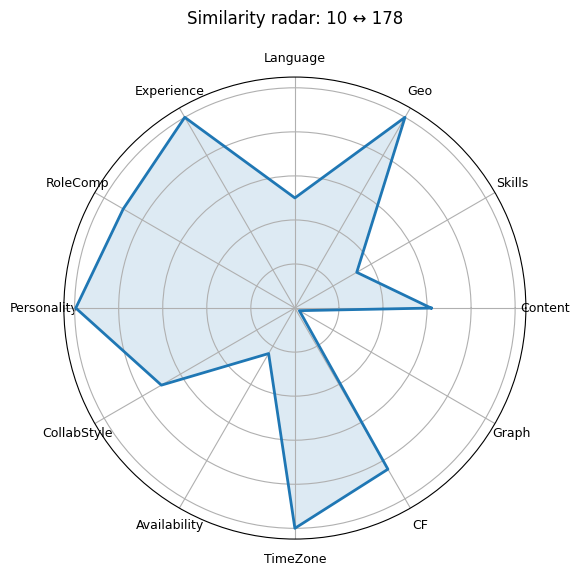

In [28]:
# Radar visualization for top local Toronto match
if not local_net.empty:
    top_name = local_net.iloc[0]['name']
    j = users.index[users.name == top_name][0]
    dims = pair_similarity_dimensions(tor_idx, j, users, signals, skills_mode="similar")
    title = f"Similarity radar: {users.iloc[tor_idx].name} ↔ {users.iloc[j].name}"
    radar_plot(dims, title=title)
